Let us first import the libraries we will need for today's workshop. 

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Now let's open the data file as a dataframe. Note that so far we have worked with `.csv` files but Python can just as easily open and manipulate other file types like `excel`. Have a quick look at your data 

In [100]:
df = pd.read_excel("covid_data.xlsx")
df.head(10)

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,Symtpm onset,tested date,COVID Symptom onset to imaging & cognitive testing (days),Admission to imaging & cognitive testing (days),Covid-19 severity (WHO Ordinal Scale),"Mechanical ventilation (1-Y,0-no)",Days mechanically ventilated,Trachy Y/N,"Lowest PaO2/FiO2 ratio (severity of lung injury, lower is worse)",Extrapulmonary organ dysfunction/support,Highest CRP during admission,Highest D-Dimer during admission,GAD-7,PHQ-9,PCL-5,GAD7 1.,GAD7 2.,GAD7 3.,GAD7 4.,GAD7 5.,GAD7 6.,GAD7 7.,PHQ9 1.,PHQ9 2.,PHQ9 3.,PHQ9 4.,PHQ9 5.,PHQ9 6.,PHQ9 7.,PHQ9 8.,PHQ9 9.,PHQ9 Difficulty,PCL5 1.,PCL5 2.,PCL5 3.,PCL5 4.,PCL5 5.,PCL5 6.,PCL5 7.,PCL5 8.,PCL5 9.,PCL5 10.,PCL5 11.,PCL5 12.,PCL5 13.,PCL5 14.,PCL5 15.,PCL5 16.,PCL5 17.,PCL5 18.,PCL5 19.,PCL5 20.,DRI_fourTowers,rs_TOL,rs_learningCurves,rs_manipulations2D,rs_motorControl,rs_prospectiveMemoryWords_1_delayed,rs_prospectiveMemoryWords_1_immediate,rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies,RTDRI_fourTowers,RTrs_learningCurves,RTrs_manipulations2D,RTrs_TOL,RTrs_motorControl,RTrs_prospectiveMemoryWords_1_delayed,RTrs_prospectiveMemoryWords_1_immediate,RTrs_spatialSpan,RTrs_targetDetection,RTrs_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,2020-05-05,NaT,38,34,6,1,14,N,8.0,Y,286,242,4,3,21,1.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1,1,3.0,3.0,1,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1,0.0,1.0,2.0,2.0,3.0,106.0,17.0,659.03,21.0,22.0,4.0,65.0,6.0,10242.0,50.764,4504.0,13709.0,13.0790,1041.0,1113.0,4245.5,1314.0,9054.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,english,2020-03-18,NaT,87,65,7,1,47,Y,10.0,Y,350,11593,1,0,5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,6.0,8.0,118.0,17.0,733.57,19.0,22.0,4.0,32.0,11.0,11151.0,50.551,8262.0,11550.0,23.0550,1010.5,1066.0,2863.0,1686.0,6167.5
2,4105609.0,54,1,Right,A levels,English,english,2020-03-22,NaT,97,90,6,1,28,Y,8.0,Y,399,3161,9,9,16,1.0,1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1,0,0.0,0.0,0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3,0.0,2.0,2.0,10.0,10.0,119.0,18.0,659.67,18.0,22.0,5.0,63.0,8.0,11171.0,50.247,6937.0,9411.0,12.0190,800.5,930.0,2383.0,1079.0,4799.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,2020-03-31,NaT,95,99,7,1,18,N,10.0,Y,405,861,4,5,13,0.0,1,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,2,0.0,2.0,2.0,-4.0,8.0,105.0,8.0,1041.30,21.0,18.0,5.0,35.0,21.0,12665.0,50.618,16940.0,11868.0,8.2759,1005.0,1676.5,2642.0,2030.5,3017.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,2020-03-10,NaT,121,111,7,1,50,Y,9.5,Y,367,952,0,0,3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1,0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,10.0,9.0,120.0,24.0,786.40,20.0,24.0,6.0,64.0,38.0,8612.5,50.792,4809.5,7010.0,28.4730,1010.0,999.0,5343.5,1376.5,3247.0
5,4303013.0,34,2,Left,A levels,English,English,2020-04-22,NaT,93,16,5,0,0,N,NaN,N,281,235,15,11,39,2.0,1,3.0,2.0,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,3.0,2.0,3.0,2,3,3.0,2.0,1,3.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1,1.0,2.0,3.0,2.0,8.0,120.0,31.0,731.57,15.0,19.0,4.0,56.0,9.0,11621.0,50.539,3961.0,8700.5,14.9220,1298.0,1079.5,5281.0,1349.0,4610.0
6,3928857.0,61,1,Left,Not done,English,English,2020-03-12,NaT,133,123,7,1,9,Y,8.5,Y,391,2985,13,10,6,2.0,2,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,1.0,3.0,2.0,2.0,2,3,2.0,2.0,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,2.0,2.0,2.0,7.0,118.0,19.0,575.67,19.0,20.0,5.0,38.0,3.0,21358.0,50.958,5902.0,15116.0,14.8830,729.0,846.5,5177.0,2259.0,3963.0
7,3929051.0,68,1,NaN,Not done,English,English,2020-03-28,2020-08-07,132,not scanned,6,1,18,Y,12.0,Y,298,nd,0,5,10,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0

Notice that not all columns are shown, as Python has a cap on how many columns it can show in a table. To help us visually the data better, we will remove that cap.

In [101]:
pd.set_option('display.max_columns', None)
df.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,Symtpm onset,tested date,COVID Symptom onset to imaging & cognitive testing (days),Admission to imaging & cognitive testing (days),Covid-19 severity (WHO Ordinal Scale),"Mechanical ventilation (1-Y,0-no)",Days mechanically ventilated,Trachy Y/N,"Lowest PaO2/FiO2 ratio (severity of lung injury, lower is worse)",Extrapulmonary organ dysfunction/support,Highest CRP during admission,Highest D-Dimer during admission,GAD-7,PHQ-9,PCL-5,GAD7 1.,GAD7 2.,GAD7 3.,GAD7 4.,GAD7 5.,GAD7 6.,GAD7 7.,PHQ9 1.,PHQ9 2.,PHQ9 3.,PHQ9 4.,PHQ9 5.,PHQ9 6.,PHQ9 7.,PHQ9 8.,PHQ9 9.,PHQ9 Difficulty,PCL5 1.,PCL5 2.,PCL5 3.,PCL5 4.,PCL5 5.,PCL5 6.,PCL5 7.,PCL5 8.,PCL5 9.,PCL5 10.,PCL5 11.,PCL5 12.,PCL5 13.,PCL5 14.,PCL5 15.,PCL5 16.,PCL5 17.,PCL5 18.,PCL5 19.,PCL5 20.,DRI_fourTowers,rs_TOL,rs_learningCurves,rs_manipulations2D,rs_motorControl,rs_prospectiveMemoryWords_1_delayed,rs_prospectiveMemoryWords_1_immediate,rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies,RTDRI_fourTowers,RTrs_learningCurves,RTrs_manipulations2D,RTrs_TOL,RTrs_motorControl,RTrs_prospectiveMemoryWords_1_delayed,RTrs_prospectiveMemoryWords_1_immediate,RTrs_spatialSpan,RTrs_targetDetection,RTrs_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,2020-05-05,NaT,38,34,6,1,14,N,8.0,Y,286,242,4,3,21,1.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1,1,3.0,3.0,1,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1,0.0,1.0,2.0,2.0,3.0,106.0,17.0,659.03,21.0,22.0,4.0,65.0,6.0,10242.0,50.764,4504.0,13709.0,13.0790,1041.0,1113.0,4245.5,1314.0,9054.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,english,2020-03-18,NaT,87,65,7,1,47,Y,10.0,Y,350,11593,1,0,5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,6.0,8.0,118.0,17.0,733.57,19.0,22.0,4.0,32.0,11.0,11151.0,50.551,8262.0,11550.0,23.0550,1010.5,1066.0,2863.0,1686.0,6167.5
2,4105609.0,54,1,Right,A levels,English,english,2020-03-22,NaT,97,90,6,1,28,Y,8.0,Y,399,3161,9,9,16,1.0,1,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1,0,0.0,0.0,0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3,0.0,2.0,2.0,10.0,10.0,119.0,18.0,659.67,18.0,22.0,5.0,63.0,8.0,11171.0,50.247,6937.0,9411.0,12.0190,800.5,930.0,2383.0,1079.0,4799.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,2020-03-31,NaT,95,99,7,1,18,N,10.0,Y,405,861,4,5,13,0.0,1,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,2,0.0,2.0,2.0,-4.0,8.0,105.0,8.0,1041.30,21.0,18.0,5.0,35.0,21.0,12665.0,50.618,16940.0,11868.0,8.2759,1005.0,1676.5,2642.0,2030.5,3017.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,2020-03-10,NaT,121,111,7,1,50,Y,9.5,Y,367,952,0,0,3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1,0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,10.0,9.0,120.0,24.0,786.40,20.0,24.0,6.0,64.0,38.0,8612.5,50.792,4809.5,7010.0,28.4730,1010.0,999.0,5343.5,1376.5,3247.0


Now you can see all 79 columns. Please go through each column and try to understand what it is that it's measuring.

There is a lot of information contained in this dataset. But for today's tutorial we do not need all of this information. Let's try to curate a smaller dataset which only contains the variables that we are interested in. We are going to keep several demographic variables, some information about COVID19 severity and 3 the results of 3 cognitive tasks.

In [102]:
df2 = pd.concat([df.loc[:, "userID":"First Language binary"], df["Mechanical ventilation (1-Y,0-no)"], df.loc[:, "rs_spatialSpan":"rs_verbalAnalogies"]], axis=1)

In [103]:
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",rs_spatialSpan,rs_targetDetection,rs_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,english,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,english,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Our dataset looks a lot more manageable now! However, some of the variable names we have are not very intuitive. Let's change the name of the cognitive tasks so that it is easier to understand what they measure.

In [104]:
df2.rename(columns = {'rs_spatialSpan':'memory_spatialSpan', 'rs_verbalAnalogies':'language_verbalAnalogies', 'rs_targetDetection':'attention_targetDetection'}, inplace = True)
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,english,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,english,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Try to change the column called `Qualifications` to `Education`

In [105]:
#CODE HERE

In [106]:
df2.dtypes

userID                               float64
Age                                    int64
Sex 1-Male 2-Female                    int64
Handedness                            object
Qualifications                        object
First Language                        object
First Language binary                 object
Mechanical ventilation (1-Y,0-no)      int64
memory_spatialSpan                   float64
attention_targetDetection            float64
language_verbalAnalogies             float64
dtype: object

Now that we have all of our data, we may want to check if the values contained in the columns are consistent. If you have a look in the `First language binary` column you will notice that some of the values are capitalised while others are not. This is a problem as any statistics we run will assume that `english` and `English` are two distinct groups. To fix this, we can choose a consistent way to show this and stick with it.

In [107]:
df2['First Language binary'] = df2['First Language binary'].str.title()
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language binary,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,Other,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,English,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,English,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,English,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,English,1,6.0,64.0,38.0


Try to do the same for the `Handedness` variable.

In [108]:
#CODE HERE

We may also wish to binarise some of our variables. This is usually done as specific statistical techniques require the data to be in a numeric format. So, it is always safer to hae your data saved in a numeric format, wherever possible. For instance, the language variable is a good example where binarization would be useful. Let's see how this can be done below.

In [109]:
# Text Data of First Language is converted into Numeric Binary Data
df_one = pd.get_dummies(df2['First Language binary'])
print(df_one)

    English  Other
0         0      1
1         1      0
2         1      0
3         1      0
4         1      0
5         1      0
6         1      0
7         1      0
8         0      1
9         1      0
10        1      0
11        0      1
12        1      0
13        0      1
14        1      0
15        1      0
16        1      0
17        1      0
18        1      0
19        1      0
20        1      0
21        1      0
22        1      0
23        1      0
24        1      0
25        1      0
26        1      0
27        1      0
28        1      0
29        0      1
30        0      1
31        0      1
32        1      0
33        1      0
34        1      0
35        0      1
36        0      1
37        0      1
38        1      0
39        1      0
40        1      0
41        1      0
42        1      0
43        0      1
44        0      1
45        0      1
46        0      1
47        1      0
48        1      0
49        1      0


Note that the two variables that were outputted are each other's opposites, so we only need one of them. Let us choose the first one, though it does not matter which one you choose as long as you understand what the values represent.

In [110]:
df2["First Language binary"] = df_one.English #Replace the old values with the numeric ones
df2.rename(columns = {'First Language binary':'First Language 1-English 0-Other'}, inplace = True) #change the name to something more meaningful
df2.head()

,userID,Age,Sex 1-Male 2-Female,Handedness,Qualifications,First Language,First Language 1-English 0-Other,"Mechanical ventilation (1-Y,0-no)",memory_spatialSpan,attention_targetDetection,language_verbalAnalogies
0,4133880.0,63,2,Right,"Some college, no degree",Polish,0,1,4.0,65.0,6.0
1,4227668.0,70,1,Right,O levels/GCSEs,English,1,1,4.0,32.0,11.0
2,4105609.0,54,1,Right,A levels,English,1,1,5.0,63.0,8.0
3,4105207.0,55,2,Right,"Some college, no degree",English,1,1,5.0,35.0,21.0
4,4239617.0,71,1,Right,Doctoral degree,English,1,1,6.0,64.0,38.0


Try to do apply the same concept of binarisation to the `Handedness` variable

In [111]:
#CODE HERE

Now, before moving forward we may also want to check the validity of the data. Are there any odd values that are not within the expected range? The best way to examine this is via plotting. Let's visualise some of the variables in the dataset

(array([10.,  0.,  0., 15.,  0.,  0., 18.,  0.,  0.,  5.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ]),
 <BarContainer object of 10 artists>)

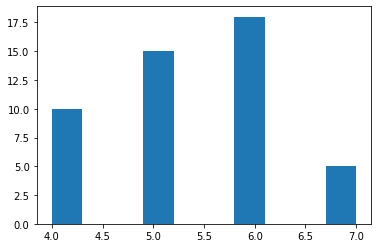

In [112]:
plt.hist(df2.memory_spatialSpan)

(array([ 2.,  5.,  1.,  4.,  4.,  5.,  6.,  4.,  6., 11.]),
 array([27. , 31.3, 35.6, 39.9, 44.2, 48.5, 52.8, 57.1, 61.4, 65.7, 70. ]),
 <BarContainer object of 10 artists>)

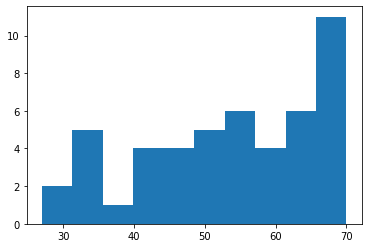

In [113]:
plt.hist(df2.attention_targetDetection)

(array([ 7.,  8.,  8., 10.,  2.,  5.,  5.,  1.,  0.,  2.]),
 array([-2. ,  2.3,  6.6, 10.9, 15.2, 19.5, 23.8, 28.1, 32.4, 36.7, 41. ]),
 <BarContainer object of 10 artists>)

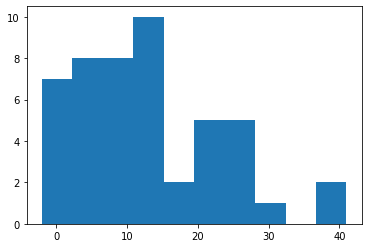

In [114]:
plt.hist(df2.language_verbalAnalogies)

(array([49.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 28. ,  86.2, 144.4, 202.6, 260.8, 319. , 377.2, 435.4, 493.6,
        551.8, 610. ]),
 <BarContainer object of 10 artists>)

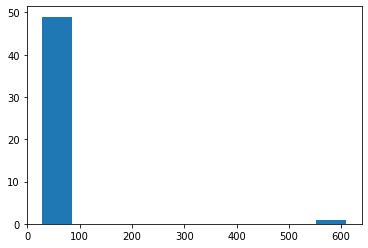

In [115]:
plt.hist(df2.Age)

We see that for the cognitive variables the data looks valid. However, when we look at age, one person seems to be over 600 years old! Unless we are dealing with a vampire, this is highly unlikely. There are multiple ways to deal with this type of data but the simplest and most straightforward is to get rid of it, by replacing it with a NaN value.

40    610
Name: Age, dtype: int64


/var/folders/01/_3yj40_538g8lmscwcv139hm0000gp/T/ipykernel_35237/1720998250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Age[df2.Age > 100] = np.NaN


(array([ 6.,  4.,  8.,  2., 10.,  3., 11.,  3.,  0.,  2.]),
 array([28. , 33.5, 39. , 44.5, 50. , 55.5, 61. , 66.5, 72. , 77.5, 83. ]),
 <BarContainer object of 10 artists>)

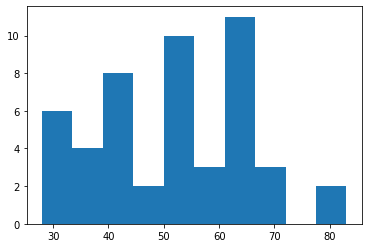

In [116]:
print(df2.Age[df2.Age > 100])
df2.Age[df2.Age > 100] = np.NaN  
plt.hist(df2.Age)


Check for the remaining variables if there is any data that is not valid. If you find anything, replace it with NaNs

Now that we have established that the data looks healthy, the next things on the list is to check whether there are any duplicated values in our dataset. The easiest way to check this is via the number of unique user IDs. If we had no duplicates, then the number of unique IDs should correspond with the total number of rows in our data.

In [120]:
print(len(np.unique(df2.userID)))

print(len(df2.userID))

48
50


From this it looks like we got two duplicates in our data. Let us try and remove them.